# import

In [1]:
pip install torchvision==0.10.0

You should consider upgrading via the '/local/python-3.7.9/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path as osp
import sys
import os
import torch

from visualize import update_config, add_path

lib_path = osp.join('lib')
add_path(lib_path)

import dataset as dataset
from config import cfg
import models
import os
import torchvision.transforms as T
import matplotlib.pyplot as plt

# path

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] ='0'
file_name = 'experiments/coco/transpose_r/TP_R_256x192_d256_h1024_enc4_mh8.yaml' # choose a yaml file

# config

In [4]:
f = open(file_name, 'r')
update_config(cfg, file_name)

# constant

In [5]:
model_name = 'T-H-A4'
assert model_name in ['T-R', 'T-H','T-H-L','T-R-A4', 'T-H-A6', 'T-H-A5', 'T-H-A4' ,'T-R-A4-DirectAttention']

normalize = T.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )

# Instance

In [6]:
trns = T.Compose([
            T.ToTensor(),
            normalize,
])

In [7]:
device = torch.device('cuda')
model = eval('models.'+cfg.MODEL.NAME+'.get_pose_net')(
    cfg, is_train=True
)

/local/python-3.7.9/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [70]:
if cfg.TEST.MODEL_FILE:
    print('=> loading model from {}'.format(cfg.TEST.MODEL_FILE))
    # model.load_state_dict(torch.load(cfg.TEST.MODEL_FILE), strict=True)
    model = torch.hub.load('yangsenius/TransPose:main', 'tpr_a4_256x192', pretrained=True)
    # model.load_state_dict(torch.load("/workspace/tp_r_256x192_enc3_d256_h1024_mh8.pth"), strict=True)
else:
    raise ValueError("please choose one ckpt in cfg.TEST.MODEL_FILE")

=> loading model from models/pytorch/transpose_coco/tp_r_256x192_enc4_d256_h1024_mh8.pth
>>Load pretrained weights from url: https://github.com/yangsenius/TransPose/releases/download/Hub/tp_r_256x192_enc4_d256_h1024_mh8.pth
Successfully loaded model  (on cpu) with pretrained weights!


Using cache found in /home/ubuntu/.cache/torch/hub/yangsenius_TransPose_main


## save

In [72]:
model_path = 'trans_pose_pytorch.pth'
torch.save(model.to('cpu').state_dict(), model_path)

In [73]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [74]:
model

TransPoseR(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

# pytorch 

## inference

#### Obtain the predictions

We feed an input sample to the model, get the predicted keypoint heatmaps and further obtain the positions of keypoints. 

In [75]:
import numpy as np 
from lib.core.inference import get_final_preds
from lib.utils import transforms, vis
import cv2

In [76]:
model.to(device)
print("model params:{:.3f}M".format(sum([p.numel() for p in model.parameters()])/1000**2))

model params:5.985M


In [77]:
%%time
with torch.no_grad():
    model.eval()
    tmp = []
    tmp2 = []
    # img = dataset[0][0]
    img = cv2.imread('/workspace/person_image.png')
    img = cv2.resize(img, dsize=(192, 256))
    img = trns(img)

    inputs = torch.cat([img.to(device)]).unsqueeze(0)    
    outputs = model(inputs)
    
    if isinstance(outputs, list):
        output = outputs[-1]
    else:
        output = outputs

    # if cfg.TEST.FLIP_TEST: 
    if False: 
        input_flipped = np.flip(inputs.cpu().numpy(), 3).copy()
        input_flipped = torch.from_numpy(input_flipped).cuda()
        outputs_flipped = model(input_flipped)

        if isinstance(outputs_flipped, list):
            output_flipped = outputs_flipped[-1]
        else:
            output_flipped = outputs_flipped

        output_flipped = transforms.flip_back(output_flipped.cpu().numpy(),
                                   dataset.flip_pairs)
        output_flipped = torch.from_numpy(output_flipped.copy()).cuda()

        output = (output + output_flipped) * 0.5
        
    preds, maxvals = get_final_preds(
            cfg, output.clone().cpu().numpy(), None, None, transform_back=False)

# from heatmap_coord to original_image_coord
query_locations = np.array([p*4+0.5 for p in preds[0]])
print(query_locations)


[[111.69811   24.535194]
 [121.601326  18.398582]
 [100.91795   19.097736]
 [133.60895   24.872992]
 [ 85.37298   24.120401]
 [139.19887   56.00161 ]
 [ 74.41413   52.44168 ]
 [167.3883    62.531895]
 [  8.795714  72.83274 ]
 [164.55646   79.69143 ]
 [ 59.015976  99.571846]
 [119.96547  129.01141 ]
 [ 73.811615 119.2519  ]
 [ 90.74989  164.30685 ]
 [124.76885  165.62425 ]
 [ 71.696304 221.33119 ]
 [125.70574  227.54787 ]]
CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 34.7 ms


## visualize

In [78]:
image_org = cv2.imread('/workspace/person_image.png')

In [79]:
pred = preds[0].copy()

In [80]:
pred[:, 0] = pred[:, 0] * image_org.shape[1] / 192
pred[:, 1] = pred[:, 1] * image_org.shape[0] / 256

In [81]:
pred = pred.astype(int) * 4

In [15]:
image_org.shape

(474, 129, 3)

In [16]:
pred

array([[ 72,  44],
       [ 80,  32],
       [ 64,  32],
       [ 88,  44],
       [ 56,  40],
       [ 92, 100],
       [ 48,  96],
       [112, 112],
       [  4, 132],
       [108, 144],
       [ 36, 180],
       [ 80, 236],
       [ 48, 216],
       [ 60, 300],
       [ 80, 304],
       [ 44, 408],
       [ 84, 420]])

In [17]:
edge_color=(0, 75, 255)
for x, y in pred:
    cv2.circle(image_org,(x,y),
               3, edge_color, -1, cv2.LINE_AA)

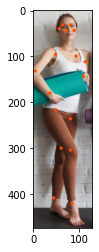

In [18]:
plt.imshow(image_org[:,:,::-1])

In [19]:
inputs.shape

torch.Size([1, 3, 256, 192])

In [20]:
outputs.shape

torch.Size([1, 17, 64, 48])

In [21]:
output_np_torch = output.clone().cpu().numpy()

In [22]:
import pandas as pd

In [23]:
import matplotlib.pyplot as plt

In [24]:
heat_org = output_np_torch[0]

In [25]:
heat_sum = heat_org.sum(axis=0)
heat_prod = heat_org.prod(axis=0)

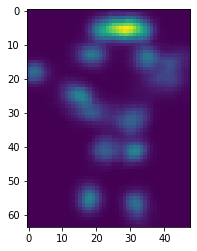

In [26]:
plt.imshow(heat_sum)

## feature map

#### Obtain the attention maps and visualize them
The attention maps can be returned by the forward function of the model, or can be hooked by the hook function of pytorch. Here we conduct the hook implementation in the function `inspect_atten_map_by_locations`. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/local/python-3.7.9/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

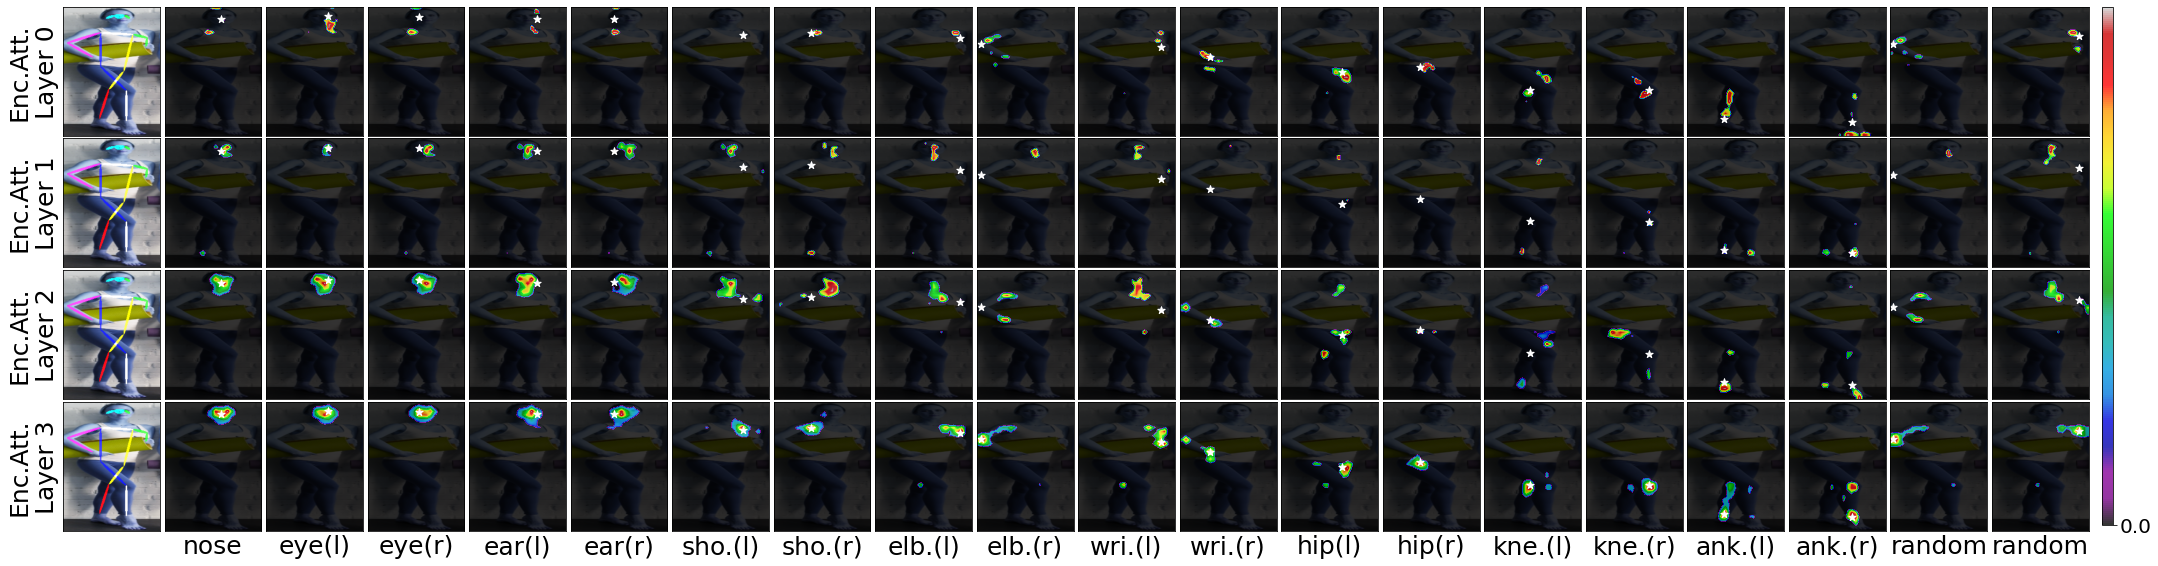

In [27]:
from visualize import inspect_atten_map_by_locations

inspect_atten_map_by_locations(img, model, query_locations, model_name="transposer", mode='dependency', save_img=True, threshold=0.01)


## convert to onnx

In [28]:
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
output_names = [ "output1" ]

In [29]:
onnx_model_save_path = "transpose.onnx"

In [30]:
torch.onnx.export(model, 
                  inputs, 
                  onnx_model_save_path, 
                  verbose=True, 
                  input_names=input_names, 
                  output_names=output_names)

graph(%actual_input_1 : Float(1, 3, 256, 192, strides=[147456, 49152, 192, 1], requires_grad=0, device=cuda:0),
      %learned_0 : Float(768, 1, 256, strides=[256, 256, 1], requires_grad=0, device=cuda:0),
      %reduce.weight : Float(256, 512, 1, 1, strides=[512, 1, 1, 1], requires_grad=1, device=cuda:0),
      %global_encoder.layers.0.self_attn.in_proj_weight : Float(768, 256, strides=[256, 1], requires_grad=1, device=cuda:0),
      %global_encoder.layers.0.self_attn.in_proj_bias : Float(768, strides=[1], requires_grad=1, device=cuda:0),
      %global_encoder.layers.0.self_attn.out_proj.bias : Float(256, strides=[1], requires_grad=1, device=cuda:0),
      %global_encoder.layers.0.linear1.bias : Float(1024, strides=[1], requires_grad=1, device=cuda:0),
      %global_encoder.layers.0.linear2.bias : Float(256, strides=[1], requires_grad=1, device=cuda:0),
      %global_encoder.layers.0.norm1.weight : Float(256, strides=[1], requires_grad=1, device=cuda:0),
      %global_encoder.layers.0

In [31]:
onnx_model_save_path

'transpose.onnx'

# onnx

## import

In [32]:
!pip install onnx==1.9.0
!pip install onnxruntime==1.8.1

You should consider upgrading via the '/local/python-3.7.9/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/local/python-3.7.9/bin/python3.7 -m pip install --upgrade pip' command.


In [33]:
import onnx
import onnxruntime as ort

## model

In [34]:


# Load the ONNX model
model = onnx.load(onnx_model_save_path)

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)

'graph torch-jit-export (\n  %actual_input_1[FLOAT, 1x3x256x192]\n) initializers (\n  %learned_0[FLOAT, 768x1x256]\n  %reduce.weight[FLOAT, 256x512x1x1]\n  %global_encoder.layers.0.self_attn.in_proj_weight[FLOAT, 768x256]\n  %global_encoder.layers.0.self_attn.in_proj_bias[FLOAT, 768]\n  %global_encoder.layers.0.self_attn.out_proj.bias[FLOAT, 256]\n  %global_encoder.layers.0.linear1.bias[FLOAT, 1024]\n  %global_encoder.layers.0.linear2.bias[FLOAT, 256]\n  %global_encoder.layers.0.norm1.weight[FLOAT, 256]\n  %global_encoder.layers.0.norm1.bias[FLOAT, 256]\n  %global_encoder.layers.0.norm2.weight[FLOAT, 256]\n  %global_encoder.layers.0.norm2.bias[FLOAT, 256]\n  %global_encoder.layers.1.self_attn.in_proj_weight[FLOAT, 768x256]\n  %global_encoder.layers.1.self_attn.in_proj_bias[FLOAT, 768]\n  %global_encoder.layers.1.self_attn.out_proj.bias[FLOAT, 256]\n  %global_encoder.layers.1.linear1.bias[FLOAT, 1024]\n  %global_encoder.layers.1.linear2.bias[FLOAT, 256]\n  %global_encoder.layers.1.norm1

In [35]:
ort_session = ort.InferenceSession(onnx_model_save_path)

In [36]:
def normalize(img: np.ndarray,
              norm_mean: np.ndarray = np.array(
                  [0.485, 0.456, 0.406]),
              norm_std: np.ndarray = np.array(
                  [0.229, 0.224, 0.225])
              ) -> np.ndarray:
    img_resize = (img - 255 * norm_mean) / (255 * norm_std)
    img_resize = img_resize.transpose(2, 0, 1)
    img_resize = img_resize.astype(np.float32)
    return img_resize

In [37]:
image_path = '/workspace/person_image.png'

In [38]:
image = cv2.imread(image_path)
# image = 
image = cv2.resize(image, dsize=(192, 256))
image = normalize(image)

In [39]:
image.shape

(3, 256, 192)

image = image.transpose(2,0,1)

In [40]:
image.shape

(3, 256, 192)

In [41]:
image = image[np.newaxis]

In [42]:
image.shape

(1, 3, 256, 192)

## inference

In [43]:
%%time
# outputs = ort_session.run(None, {'actual_input_1': np.random.randn(1, 3, 256, 192).astype(np.float32)})
outputs = ort_session.run(None, 
                          {'actual_input_1': image.astype(np.float32)})

# print(outputs[0])

CPU times: user 180 ms, sys: 7.34 ms, total: 187 ms
Wall time: 63.2 ms


In [44]:
outputs[0].shape

(1, 17, 64, 48)

## test

In [45]:
output_np_onnx = outputs[0]

In [46]:
np.testing.assert_allclose(output_np_torch,
                               output_np_onnx,
                               rtol=1e-03,
                               atol=1e-05)

## feature map

In [47]:
output_np_onnx.shape

(1, 17, 64, 48)

In [48]:
heat_org = output_np_onnx[0]

In [49]:
heat_org.shape

(17, 64, 48)

In [50]:
heat_sum = heat_org.sum(axis=0)
heat_prod = heat_org.prod(axis=0)

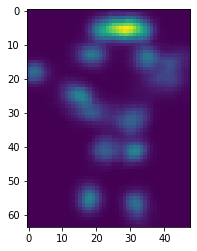

In [51]:
plt.imshow(heat_sum)

# vis

In [52]:
preds, maxvals = get_final_preds(
            cfg, outputs[0], None, None, transform_back=False)

In [53]:
for pred in preds:
    pred

In [54]:
preds[0]

array([[27.799528 ,  6.0087986],
       [30.275333 ,  4.474645 ],
       [25.104488 ,  4.6494336],
       [33.277237 ,  6.093248 ],
       [21.218245 ,  5.9050984],
       [34.674713 , 13.875402 ],
       [18.47853  , 12.985421 ],
       [41.722076 , 15.507971 ],
       [ 2.0739286, 18.083185 ],
       [41.014114 , 19.797855 ],
       [14.628991 , 24.767962 ],
       [29.866367 , 32.127853 ],
       [18.327904 , 29.687975 ],
       [22.562473 , 40.951714 ],
       [31.067213 , 41.281063 ],
       [17.799076 , 55.207798 ],
       [31.301435 , 56.761967 ]], dtype=float32)

In [55]:
maxvals[0]

array([[0.9770028 ],
       [0.9375319 ],
       [0.9863762 ],
       [0.90248895],
       [0.92318016],
       [0.77313495],
       [0.79205245],
       [0.29339185],
       [0.6821043 ],
       [0.2996673 ],
       [0.86495966],
       [0.5815981 ],
       [0.57856435],
       [0.5658003 ],
       [0.8821787 ],
       [0.86299574],
       [0.7235065 ]], dtype=float32)

In [56]:
pred = preds[0].copy()

In [57]:
pred[:, 0] = pred[:, 0] * image_org.shape[1] / 192
pred[:, 1] = pred[:, 1] * image_org.shape[0] / 256

In [58]:
pred = pred.astype(int) * 4

In [59]:
pred

array([[ 72,  44],
       [ 80,  32],
       [ 64,  32],
       [ 88,  44],
       [ 56,  40],
       [ 92, 100],
       [ 48,  96],
       [112, 112],
       [  4, 132],
       [108, 144],
       [ 36, 180],
       [ 80, 236],
       [ 48, 216],
       [ 60, 300],
       [ 80, 304],
       [ 44, 408],
       [ 84, 420]])

In [60]:
pose_rets = np.zeros((17, 3))

In [61]:
pose_rets[:, 0:2] = preds[0]

In [62]:
pose_rets

array([[27.79952812,  6.0087986 ,  0.        ],
       [30.2753334 ,  4.47464514,  0.        ],
       [25.10448837,  4.64943361,  0.        ],
       [33.27723694,  6.09324789,  0.        ],
       [21.21824455,  5.90509844,  0.        ],
       [34.67471313, 13.87540245,  0.        ],
       [18.47853088, 12.98542118,  0.        ],
       [41.72207642, 15.50797081,  0.        ],
       [ 2.07392859, 18.0831852 ,  0.        ],
       [41.01411438, 19.79785538,  0.        ],
       [14.62899113, 24.7679615 ,  0.        ],
       [29.86636734, 32.12785339,  0.        ],
       [18.32790375, 29.68797493,  0.        ],
       [22.5624733 , 40.95171356,  0.        ],
       [31.06721306, 41.28106308,  0.        ],
       [17.79907608, 55.207798  ,  0.        ],
       [31.30143547, 56.76196671,  0.        ]])

In [63]:
image_org.shape

(474, 129, 3)

In [64]:
pred

array([[ 72,  44],
       [ 80,  32],
       [ 64,  32],
       [ 88,  44],
       [ 56,  40],
       [ 92, 100],
       [ 48,  96],
       [112, 112],
       [  4, 132],
       [108, 144],
       [ 36, 180],
       [ 80, 236],
       [ 48, 216],
       [ 60, 300],
       [ 80, 304],
       [ 44, 408],
       [ 84, 420]])

In [65]:
image.shape

(1, 3, 256, 192)

In [66]:
image_org = cv2.imread('/workspace/person_image.png')

In [67]:
edge_color=(0, 75, 255)
for x, y in pred:
    cv2.circle(image_org,(x,y),
               3, edge_color, -1, cv2.LINE_AA)

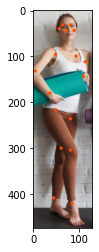

In [68]:
plt.imshow(image_org[:,:,::-1])

## feature map

In [69]:
# TODO